# **Особенности машинного обучения на временных рядах**

## <div style="padding: 30px;color:white;margin:0;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#17202a "><b><span style='color:#E888BB'>1 ❯</span></b> <b>BACKGROUND</b></div>

### <b><span style='color:#E888BB;text-align:center'>❯❯ </span>Описание Задачи</b>

Имея данные биржовых акции, давайте создадим модели которые будут предсказывать будуйщее

Разделим задачу на вде части:
- В первой части создадим **бинарных классификатор** которы будет предсказывать повысится ли стоимость через X или нет
- В второй части создадим **регрессор**, и будем предсказывать динамику биржовой цены 

Создадим признаки на базе которых мы будем обучать модели
- В отличии от ситуации когда мы уже имели все данные и просто классифицируем
- В данном примере мы хотим **предсказать будуйшее** (ряд еще не достроен)



In [2]:
%%capture

!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib kaleido yfinance catboost

In [3]:
import talib
import plotly
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import figure
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import talib as ta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix
import warnings;warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## <div style="padding: 30px;color:white;margin:0;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#17202a "><b><span style='color:#E888BB'>2 ❯</span></b> <b>Загрузка Данных</b></div>

- Стандартные биржовые признаки `open`, `close`, `high`, `low` & `vol`
- Периуд данных [2012-05-07-2023-05-05] с интервалом 1 день

In [4]:
import yfinance as yf

tickers = ['AAPL','MSFT','AMZN','GOOG',
           'AMD','NVDA','TSLA','YELP',
           'NFLX','ADBE','BA','AIG']

start = '2012-05-05'
end = '2023-05-05'
df_ticker = pd.DataFrame()
for ticker in tickers:
    ticker_yf = yf.Ticker(ticker)
    if df_ticker.empty:
        df_ticker = ticker_yf.history(start = start, end = end, interval='1d')
        df_ticker['ticker']= ticker
    else:
        data_temp = ticker_yf.history(start = start, end = end, interval='1d')
        data_temp['ticker']= ticker
        df_ticker = df_ticker.append(data_temp)

# df_ticker = pd.read_csv('return_data.csv',index_col=['Datetime'])
df_ticker['ticker'] = df_ticker['ticker'].replace({'META':'FB'})
df_ticker.index = pd.to_datetime(df_ticker.index)
print(df_ticker['ticker'].unique())

['AAPL' 'MSFT' 'AMZN' 'GOOG' 'AMD' 'NVDA' 'TSLA' 'YELP' 'NFLX' 'ADBE' 'BA'
 'AIG']


In [5]:
print(f'Data size: {df_ticker.shape[0]/12}')
print(f'Step size: {df_ticker.index[1] - df_ticker.index[0]}')
print(f'isna().sum() =\n{df_ticker.isna().sum()}')

Data size: 2767.0
Step size: 1 days 00:00:00
isna().sum() =
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
ticker          0
dtype: int64


In [6]:
df = dict(tuple(df_ticker.groupby(['ticker'])))['MSFT']
df.index

DatetimeIndex(['2012-05-07 00:00:00-04:00', '2012-05-08 00:00:00-04:00',
               '2012-05-09 00:00:00-04:00', '2012-05-10 00:00:00-04:00',
               '2012-05-11 00:00:00-04:00', '2012-05-14 00:00:00-04:00',
               '2012-05-15 00:00:00-04:00', '2012-05-16 00:00:00-04:00',
               '2012-05-17 00:00:00-04:00', '2012-05-18 00:00:00-04:00',
               ...
               '2023-04-21 00:00:00-04:00', '2023-04-24 00:00:00-04:00',
               '2023-04-25 00:00:00-04:00', '2023-04-26 00:00:00-04:00',
               '2023-04-27 00:00:00-04:00', '2023-04-28 00:00:00-04:00',
               '2023-05-01 00:00:00-04:00', '2023-05-02 00:00:00-04:00',
               '2023-05-03 00:00:00-04:00', '2023-05-04 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=2767, freq=None)

#### <b><span style='color:#E888BB;text-align:center'>❯❯❯ </span>Визуализация Данных</b>

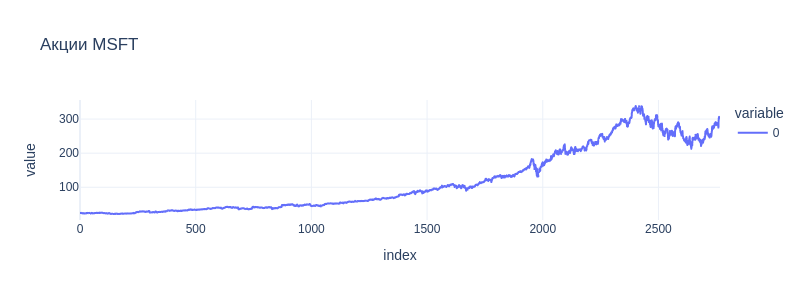

In [7]:
fig = px.line(df.Close.values,template='plotly_white',
              height=300,width=800,title='Акции MSFT')
fig.show('png',dpi=300)

## <div style="padding: 30px;color:white;margin:0;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#17202a "><b><span style='color:#E888BB'>3 ❯</span></b> <b>Понижение Размерности</b></div>

- Данных достаточно много, понизим размерности sampling с помощью resample
- Берем часовые интервалы, в котором берем:
    - первый `open` в интервале
    - максимальных `high` и минимальный `min`
    - сумма `vol` и последний `close`

In [9]:
# print(f'df.shape (before) = {df.shape}')

# как аггрегировать различные колонки
# conversion = {
#                 'Open'  : 'first', ## цена открытия - первое значение
#                 'High'  : 'max',   ## пиковое значение - максимум
#                 'Low'   : 'min',   ## наименьшее значение - минимум
#                 'Close' : 'last',  ## цена закрытия - последнее значение
#                 'Volume'   : 'sum',   ## объём - сумма
#              }

# понижаем разрешение до часовых значений

# df = df.resample('1h').apply(conversion) # main funct
# df = df.reset_index()
# df = df.dropna()

# print(f'df.shape (after) = {df.shape}')

h1 = df.copy()

## <div style="padding: 30px;color:white;margin:0;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#17202a "><b><span style='color:#E888BB'>4 ❯</span></b> <b>Feature Engineering</b></div>

### <b><span style='color:#E888BB;text-align:center'>❯❯ </span>Технические индикаторы с talib</b>

- С помошью `talib` мы можем дегко создавать технические индикаторы для временных рядов
- Для разметки возмем сдвиг **shift(-1) что сдвигает series вверх**, получаем завтрашние данные day + 1

In [10]:
df = h1.copy()

features = pd.DataFrame()
features.index = df.index

# добавляем фичи: объём сделок
features['vol_0']   = df.Volume
features['vol_1']   = df.Volume.shift(1) ## за предыдущий день
features['vol_2']   = df.Volume.shift(2) ## за предпредыдущий день
features['LMA'] = df['Close'].rolling(window=15, min_periods=1, center=False).mean()

# индикаторы технического анализа из библиотеки ta-lib

period = 14 # окно на котором будут рассчитываться индикаторы

# RSI:
features['RSI1'] = ta.RSI(df.Close.values, period)

# ## прочие индикаторы (требуют все значения свечи: open, close, high, low)
features['willr'] = ta.WILLR(df.High.values, df.Low.values, df.Close.values, period)
features['BOP']   = ta.BOP(df.Open.values, df.High.values, df.Low.values, df.Close.values)
features['MOM']   = ta.MOM(df.Close.values, period)
features['MOM10']   = ta.MOM(df.Close.values,period*10)
features['mdm']   = ta.MINUS_DM(df.High.values, df.Low.values, period)
features['pdm']   = ta.PLUS_DM(df.High.values, df.Low.values, period)
features['arosc'] = ta.AROONOSC(df.High.values, df.Low.values, period)

# ## создаём список фич
featuresList = features.columns.values

# ## добавляем таймстемп
features['ts'] = h1.index

### <b><span style='color:#E888BB;text-align:center'>❯❯ </span>Метки для Бинарной Классификации</b>

Создаем лейбл для классификации: возрастёт ли цена через X часов или упадёт?
- 1 = цена возрастёт, 0 = цена упадёт

In [11]:
 # разница между текущей ценой и ценой через 1 час
features['deltaPrice'] = df.Close.shift(-1) - df.Close # next day - today

# лейбл для классификации: возрастёт ли цена через X часов или упадёт?
features['label'] = np.where(features['deltaPrice'] > 0, 1, 0)
features = features.dropna()

print("Features:")
print(featuresList)
print(f'features.shape = {features.shape}')

Features:
['vol_0' 'vol_1' 'vol_2' 'LMA' 'RSI1' 'willr' 'BOP' 'MOM' 'MOM10' 'mdm'
 'pdm' 'arosc']
features.shape = (2626, 15)


### <b><span style='color:#E888BB;text-align:center'>❯❯ </span>Визуализация Технических индикаторов</b>

test.shape = (2767, 3)


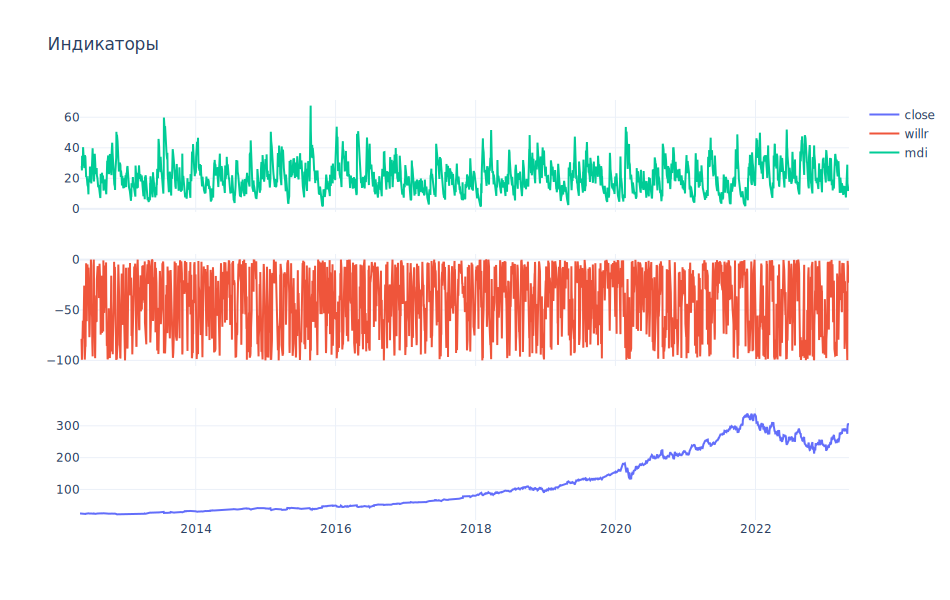

In [12]:
test = pd.DataFrame()
test.index = h1.index

## задаём окно
period = 7

## индикаторы
test['willr'] = ta.WILLR(h1.High.values, h1.Low.values, h1.Close.values, period)
test['mdi']   = ta.MINUS_DI(h1.High.values, h1.Low.values, h1.Close.values, period)

# цена закрытия
test['Close'] = h1.Close

print(f'test.shape = {test.shape}')
# берём каждую десятую точку (быстрее отображается)
# test = test.iloc[::10]
# test = test.dropna()

# создаём графики для цены закрытия и индикаторов
trace1 = go.Scatter(x=test.index, y=test.Close, name='close')
trace2 = go.Scatter(x=test.index, y=test.willr, name='willr')
trace3 = go.Scatter(x=test.index, y=test.mdi, name='mdi')

# создаём фигуру, состоящую из нескольких подфигур
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1,
                    specs=[[{}], [{}], [{}]],
                    shared_xaxes=True,
                    shared_yaxes=False,
                    vertical_spacing=0.1
                    )

## добавляем графики на фигуры
fig.append_trace(trace1, 3, 1)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 1, 1)

fig['layout'].update(height=600, width=950, title='Индикаторы')
fig.update_layout(template='plotly_white')

fig.show('svg',dpi=300)

## <div style="padding: 30px;color:white;margin:0;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#17202a "><b><span style='color:#E888BB'>5 ❯</span></b> <b>Разбиваем Временные Ряды</b></div>

### <b><span style='color:#E888BB;text-align:center'>❯❯ </span>TRAIN/TEST SPLIT</b>

Разбиваем данные на две родгруппы, стандартный `tts`

In [13]:
splitCoef = 0.01 # 80 - тренировочный сет, 20 - тестовый сет

## считаем, сколько цен выше, и сколько ниже текущей (насколько сбалансирован дейтасет)
countPos = len(features[features.label == 1])
countNeg = len(features[features.label == 0])
print('total')
print(f'Pos: {countPos}   Neg: {countNeg}\n')

# разбиение случайным образом
# features_train, features_test = train_test_split(features, test_size=1-splitCoef, random_state=43)
# разбиение по порядку
features_train, features_test = train_test_split(features,test_size=splitCoef,shuffle=False)

print(f'train start: {features_train.ts.iloc[0]}')
print(f'train end:   {features_train.ts.iloc[-1]}')
print(f'test start:  {features_test.ts.iloc[0]}')
print(f'test end:    {features_test.ts.iloc[-1]}')

# подготавливаем сеты
x_train = features_train[featuresList]
x_test  = features_test[featuresList]
y_train = features_train.label
y_test  = features_test.label

total
Pos: 1390   Neg: 1236

train start: 2012-11-27 00:00:00-05:00
train end:   2023-03-24 00:00:00-04:00
test start:  2023-03-27 00:00:00-04:00
test end:    2023-05-03 00:00:00-04:00


## <div style="padding: 30px;color:white;margin:0;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#17202a "><b><span style='color:#E888BB'>6 ❯</span></b> <b>Обучаем Классификатор</b></div>

### <b><span style='color:#E888BB;text-align:center'>❯❯ </span>Классовое распределение весов</b>

Для `catboost` можем дополнительное поменять распределение классовых весов, это особенно актуально для дисбалансов классов

In [14]:
# Расспределение классов можно учесть с compute_class_Weigh
from sklearn.utils.class_weight import compute_class_weight

print(y_train.value_counts())

classes = np.unique(y_train)
print(classes)
weights = compute_class_weight(
                               class_weight='balanced',
                               classes=classes,
                               y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

1    1378
0    1221
Name: label, dtype: int64
[0 1]


{0: 1.0642915642915642, 1: 0.943033381712627}

### <b><span style='color:#E888BB;text-align:center'>❯❯ </span>Обучение классификатора</b>

Обучим градиентный бустинг `CatBoostClassifier` с базовыми признаками

In [15]:
from catboost import CatBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

catparams = {
            #  'l2_leaf_reg':1000,
            #  'random_state':32,
            #  'iterations':3000,
            #  'learning_rate':0.1,
            #  'class_weights':class_weights,
            #  'bagging_temperature':0.001,
             'silent':True}

# fit model
clf = CatBoostClassifier(**catparams).fit(x_train,y_train)
# clf = LinearDiscriminantAnalysis()
clf.fit(x_train,y_train)

# результаты
res = features_test.copy()
res['pred'] = clf.predict(x_test)
res['pred_proba'] = clf.predict_proba(x_test)[:, 1] ## вероятности принадлежности классу 1

### <b><span style='color:#E888BB;text-align:center'>❯❯ </span>Оценка Классификатора</b>

Оценвиаем классификатор по двум критериям `accuracy` и `ROC`
- Оценка качества accuracy нам дает точность предсказания для **threshold 0.5**
- `ROC` дает оценку качества модели для разных пороговых значении threshold
- Оптимальное пороговое значение можно найти с помощью **max(TPR-FPR)**
    - Максимизируем `TPR`, минимизируем `FPR`

Threshold value is: 0.5106559932577258

AUC = 0.711	Accuracy = 0.630



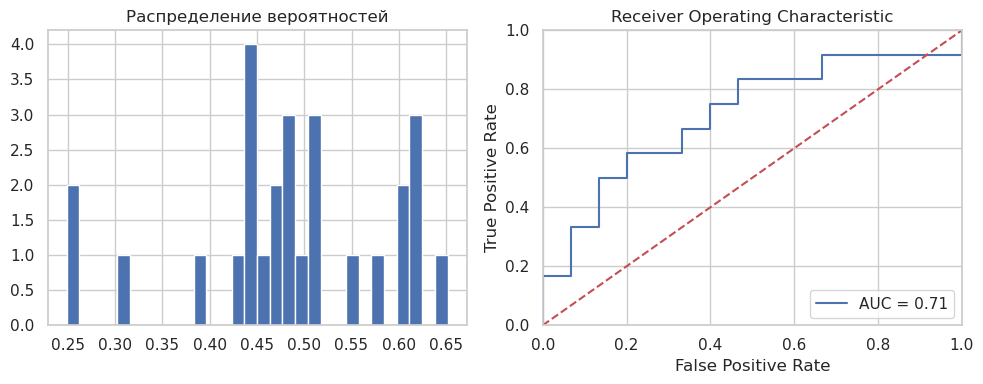

In [16]:
import seaborn as sns; sns.set(style='whitegrid')

# выводим вероятности (уверенность классификтора)

fi,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(res.pred_proba,bins=30)
ax[0].set_title('Распределение вероятностей')

# ошибки первого/второго рода и площать под ROC-кривой
FPR, TPR, thresholds = roc_curve(res.label, res.pred_proba)
roc_auc = auc(FPR, TPR)

# оптимальный порог для классификации
optimal_idx = np.argmax(TPR - FPR)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

# точность
acc = len(res[res.pred == res.label]) / len(res)
print(f"\nAUC = {roc_auc:.3f}\tAccuracy = {acc:.3f}\n")

# ROC-кривая
ax[1].set_title('Receiver Operating Characteristic')
ax[1].plot(FPR, TPR, 'b', label=f'AUC = {roc_auc:.2f}')
ax[1].legend(loc='lower right')
ax[1].plot([0, 1], [0, 1], 'r--')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')
plt.tight_layout()
plt.show()

In [18]:
# матрица ошибок
CM = confusion_matrix(res.label, res.pred)
CM_DF = pd.DataFrame(data=CM, columns = ['Pos', 'Neg'])
print('\n\nConfusion matrix:')
CM_DF



Confusion matrix:


,Pos,Neg
0,10,5
1,5,7


### <b><span style='color:#E888BB;text-align:center'>❯❯ </span>Важные Признаки</b>

Самые важные признаки из модели

In [20]:
## значительность различных фич (feature importance)
ftmprt = pd.DataFrame()
ftmprt['features'] = featuresList
ftmprt['importances'] = clf.feature_importances_
ftmprt = ftmprt.sort_values('importances', ascending=False).reset_index(drop=True)
print(ftmprt.head(10))

  features  importances
0      BOP    11.475951
1    vol_2    10.940661
2    vol_1    10.215244
3    willr     9.672942
4    vol_0     9.661190
5     RSI1     7.749184
6      LMA     7.626725
7      mdm     6.833816
8    arosc     6.684506
9    MOM10     6.545823


## <div style="padding: 30px;color:white;margin:0;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#17202a "><b><span style='color:#E888BB'>7 ❯</span> Обучаем Регрессор</b></div>


Воспользуемя тем же набором признаков как и в классификации
    

In [23]:
features_train.head(1).columns

Index(['vol_0', 'vol_1', 'vol_2', 'LMA', 'RSI1', 'willr', 'BOP', 'MOM',
       'MOM10', 'mdm', 'pdm', 'arosc', 'ts', 'deltaPrice', 'label'],
      dtype='object')

In [56]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# sns.set({"grid.color": ".6", "grid.linestyle": ":"})
sns.set_style("whitegrid", {"grid.color": ".5", "grid.linestyle": ":"})

## предсказывать будем изменение цены
y_train_values = features_train.deltaPrice.values
y_test_values  = features_test.deltaPrice.values

## параметры для регрессора
rfRegressorParams = {'n_estimators': 1000,
                     'max_depth': 10,
                     'min_samples_split': 5,
                     'max_features' : 1.0}

## обучаем
rgs = RandomForestRegressor(**rfRegressorParams)
# rgs = HistGradientBoostingRegressor()
rgs.fit(x_train, y_train_values)

## применяем на тестовых данных
y_pred_values = rgs.predict(x_test)

print('RMSE: ',mean_squared_error(y_test_values,y_pred_values,squared=False))
print('y_test_values mean: ',np.mean(y_test_values))

RMSE:  5.273953349351167
y_test_values mean:  1.0728398075810186


In [25]:
y_pred_values

array([-0.06634456,  0.33899738, -0.21315316, -0.00264486, -0.66301309,
       -0.22613101, -0.07564346, -0.20487035, -0.42682511, -0.02224715,
       -0.04698163,  0.28295432,  0.01322574, -0.21992817,  0.28357387,
        0.14028292,  0.02675805, -0.09454659,  0.10296832,  0.06555934,
        1.36162034, -0.37465602, -1.09982678, -0.76912443, -0.35951312,
       -0.10130011,  0.1729671 ])

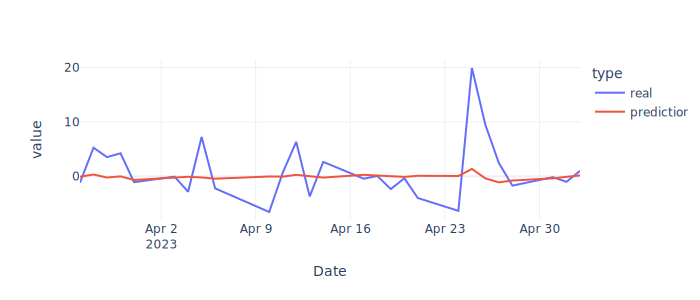

In [50]:
def compare_test_plot(y,y_pred,index=False):

    # визуализируем результат
    output = pd.DataFrame()
    output1 = pd.DataFrame({'values':y_test_values})
    output1['type'] = 'real'
    output1.index = index
    
    output2 = pd.DataFrame({'values':y_pred_values})
    output2['type'] = 'prediction'
    output2.index = index
    output = pd.concat([output1,output2])

    fig = px.line(output,color='type',template='plotly_white',height=300)
    fig.show('svg',dpi=300)
    
compare_test_plot(y_test_values,y_pred_values,features_test.index)